# Spotify Extended History

The following notebook is an experimental exploration of Spotify's **Extended History**.
The data is requested from Spotify and contains every individual play (by my account) from **October 2015** until **March 2023**.

In [22]:
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import ipywidgets
from IPython.display import Markdown, display
from dotenv import load_dotenv

In [6]:
data_source = "./data/niklas/"
paths = Path(data_source).glob("Streaming*.json")
df = pd.concat(map(pd.read_json, paths))
df.iloc[[0,-1]]

,ts,username,platform,ms_played,conn_country,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,...,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2023-05-29T18:08:46Z,niklas8351,android,202986,DE,109.40.241.142,unknown,I Just Can't Wait to Be King,JD McCrary,The Lion King,...,None,None,None,trackdone,trackdone,False,False,False,1685383522,False
16686,2017-04-17T17:06:23Z,niklas8351,Partner android_tv Amazon;AFTM;;,1260,DE,31.19.233.119,unknown,...ins Licht (Outro),Kontra K,Aus dem Schatten ins Licht,...,NaN,NaN,NaN,fwdbtn,fwdbtn,False,0.0,False,0,False


Remove known artists, that cannot be used in a music listening analysis. 

In [7]:
df.drop(columns=["username", "ip_addr_decrypted", "user_agent_decrypted", "offline_timestamp", "incognito_mode"], inplace=True)
df = df.drop(df[df["master_metadata_album_artist_name"] == "Die drei !!!"].index)
df = df.drop(df[df["master_metadata_album_artist_name"] == "Rick Riordan"].index)

In [8]:
df["ts"] = pd.to_datetime(df["ts"])
original_length = len(df)

In [9]:
unique_tracks = df["master_metadata_track_name"].unique()
print(len(unique_tracks), "unique tracks have been played")

10066 unique tracks have been played


In [11]:
df.groupby(df["master_metadata_track_name"])["spotify_track_uri"].first().to_frame().to_csv("tracks_with_uri_niklas.csv")

---
**Data:**
- `df` All columns; Only songs that have been played at least 10 times.
- `df_orig` All columns.
- `unique_tracks` Every track played.

**Edit:**
Upon further inspection, the 2015 data appear to be characterisec by irregular usage and a general lack of significance and thus will be excluded from the dataset.

In [12]:
df_top_tracks = df["master_metadata_track_name"].value_counts().to_frame()
df_top_tracks = df_top_tracks.reset_index().rename(columns={"master_metadata_track_name":"name","count":"plays"})
df_top_tracks.head()

,name,plays
0,Intro,1006
1,Adrenalin,363
2,91's,332
3,Jusqu'au dernier gramme,301
4,Palmen aus Plastik,291


In [13]:
top_names = df_top_tracks[df_top_tracks["plays"]>=10]["name"]
df_orig = df
df = df[df["master_metadata_track_name"].isin(top_names)].reset_index(drop=True)
# Edit:
df = df[df["ts"].dt.year != 2015]

print("original length:", original_length)
print(" reduced length:", len(df))
print("      reduction:", str(round(len(df)/original_length*100,2))+"%")

original length: 134592
 reduced length: 103258
      reduction: 76.72%


<div class="alert alert-block alert-success"> 
    It could be useful to further only include tracks,
    that have been played at lead 30% (or 50%) of their length. <br>
    Including skipped tracks carries the risk of further distorting the real hearing-bahavior.

</div>

In [14]:
num_skipped = len(df_orig[df_orig["skipped"] == 1])
print(round(num_skipped/len(df_orig)*100,2), "% of tracks have been skipped.") 

10.04 % of tracks have been skipped.


Though only a small percentage of tracks have been skipped, it is unlikeley, that the remaining tracks have been played to the end.


In [15]:
reason_end_count = df_orig["reason_end"].value_counts(normalize=True).to_frame().reset_index().rename({"count":"reason_end"}, axis=1)
reason_end_count

,reason_end,proportion
0,trackdone,0.525796
1,fwdbtn,0.243031
2,endplay,0.142482
3,logout,0.047833
4,unexpected-exit-while-paused,0.020551
5,backbtn,0.010506
6,remote,0.003514
7,clickrow,0.002593
8,unexpected-exit,0.001323
9,unknown,0.001323


<Axes: xlabel='proportion', ylabel='reason_end'>

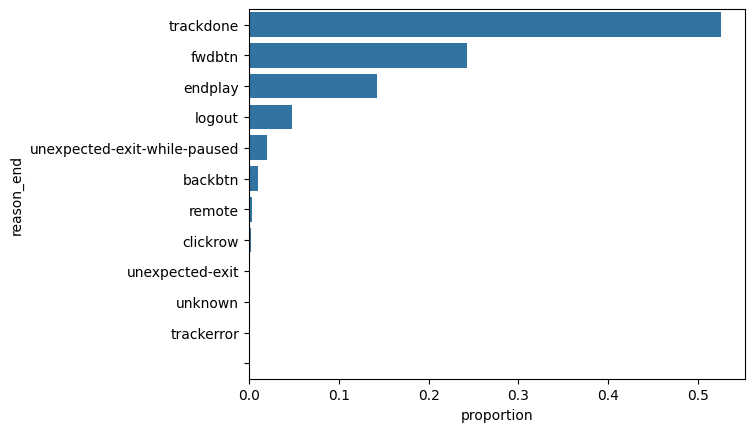

In [16]:
sns.barplot(data=reason_end_count, x="proportion", y="reason_end")

---
Songs played per year.

(only skipped excluded)

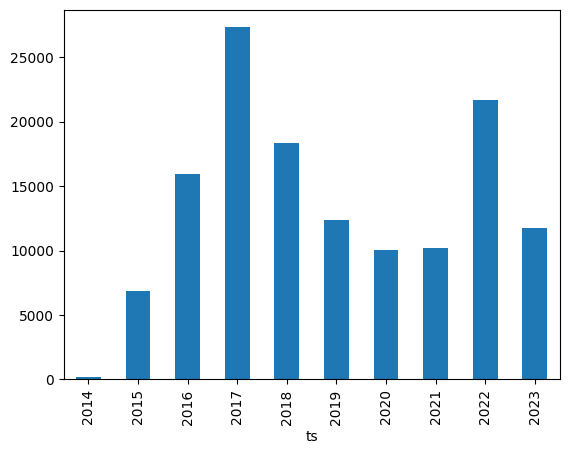

In [17]:
df_orig.groupby(df_orig["ts"].dt.year)["ts"].count().plot(kind="bar")
plt.show()

---
Songs per year per quarter.

<Axes: xlabel='ts'>

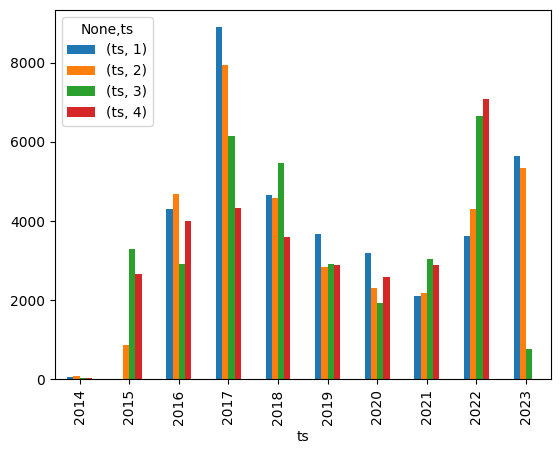

In [18]:
df_my = df_orig.groupby([df_orig["ts"].dt.year, df_orig["ts"].dt.quarter])["ts"].agg("count").to_frame()
df_my.index.sortlevel(0, sort_remaining=True)
df_my.unstack().plot(kind="bar", stacked=False)

---
Finding the longes heared tracks.

In [23]:
##### config ######
calculate = True
###################

if calculate:
    df_playcount = df["master_metadata_track_name"].value_counts().to_frame()
    df_from_to = pd.DataFrame(columns=["track_name", "plays", "first_played", "last_played", "days_between", "days_played"])

    for song, plays in tqdm(df_playcount.iterrows(), total=df_playcount.shape[0]):
        first_ts = df[df["master_metadata_track_name"] == song].iloc[0]["ts"]
        last_ts = df[df["master_metadata_track_name"] == song].iloc[-1]["ts"]

        df_ts = df.set_index("ts")
        df_ts_filtered = df_ts[df_ts["master_metadata_track_name"] == song]
        days_played = len(df_ts_filtered.groupby(df_ts_filtered.index.date).count())

        row = {
            "track_name": song,
            "plays": plays.values[0],
            "first_played": first_ts,
            "last_played": last_ts,
            "days_between": (last_ts - first_ts).days,
            "days_played": days_played,
        }
        new_df = pd.DataFrame([row])
        df_from_to = pd.concat([df_from_to, new_df], ignore_index=True)

    df_from_to.to_csv("df_from_to_niklas.csv")
else:
    df_from_to = pd.read_csv("df_from_to_niklas.csv")

df_from_to

  0%|                                                  | 0/2079 [00:00<?, ?it/s]/tmp/ipykernel_13088/188172646.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_from_to = pd.concat([df_from_to, new_df], ignore_index=True)
100%|███████████████████████████████████████| 2079/2079 [01:26<00:00, 24.16it/s]


,track_name,plays,first_played,last_played,days_between,days_played
0,Intro,1006,2023-06-11 17:02:18+00:00,2017-04-17 16:20:50+00:00,-2247,521
1,Adrenalin,363,2017-04-17 17:59:03+00:00,2017-04-15 16:06:53+00:00,-3,246
2,91's,332,2023-06-03 17:06:12+00:00,2020-03-10 16:22:57+00:00,-1181,267
3,Jusqu'au dernier gramme,301,2023-06-18 17:54:35+00:00,2017-04-15 13:34:44+00:00,-2256,242
4,Palmen aus Plastik,291,2017-04-19 13:18:32+00:00,2017-04-17 15:41:11+00:00,-2,206
...,...,...,...,...,...,...
2074,Trap Queen,1,2016-01-09 21:39:05+00:00,2016-01-09 21:39:05+00:00,0,1
2075,All About That Bass,1,2018-07-11 17:22:45+00:00,2018-07-11 17:22:45+00:00,0,1
2076,Five More Hours,1,2016-06-24 20:59:37+00:00,2016-06-24 20:59:37+00:00,0,1
2077,I Want You To Know,1,2016-06-24 21:01:58+00:00,2016-06-24 21:01:58+00:00,0,1


---
Top five songs per year with individual plays.

In [25]:
df.groupby(df["ts"].dt.year)["master_metadata_track_name"].value_counts().groupby(level=0, group_keys=False).head(5)

ts    master_metadata_track_name      
2014  Pompeii                               8
      Marteria Girl                         5
      Bangarang (feat. Sirah)               4
      Billie Jean                           4
      Endboss                               4
2016  Headlights (feat. Ilsey)            158
      Yellow                              118
      Wake Me Up - Radio Edit             112
      Lean On (feat. MØ & DJ Snake)        86
      Lush Life                            84
2017  Intro                               602
      Palmen aus Plastik                  219
      Großes Kaliber                      218
      Adrenalin                           214
      Ohne mein Team                      201
2018  Intro                               124
      Erfolg                              117
      Fame (feat. RAF Camora)              94
      Telenovela                           89
      Alles wird gut                       82
2019  91's                               

---
Histogram individual plays, per year.

In [26]:
plays_by_year = df.groupby(df["ts"].dt.year)["master_metadata_track_name"].value_counts().to_frame()
plays_by_year.index.rename(["year", "track_name"], inplace=True)
plays_by_year = plays_by_year.reset_index()
plays_by_year.rename({"count":"individual_plays"},axis=1, inplace=True)
plays_by_year.head(3)

,year,track_name,individual_plays
0,2014,Pompeii,8
1,2014,Marteria Girl,5
2,2014,Bangarang (feat. Sirah),4


In [27]:
# pby = plays_by_year[plays_by_year["individual_plays"] < 50]
sea = sns.FacetGrid(plays_by_year[["year", "individual_plays"]], col="year", col_wrap=3)

plot = sea.map_dataframe(sns.histplot, "individual_plays", stat="percent", discrete=True)
year_counts = plays_by_year["individual_plays"].groupby(plays_by_year["year"]).count().reset_index(name="plays").set_index("year")
### Jupyter Setup ###
out1 = ipywidgets.widgets.Output()
with out1:
    display(year_counts)
out2 = ipywidgets.widgets.Output()
with out2:
    display(plot)
    plt.show()
two_columns = ipywidgets.widgets.HBox([out1, out2])
display(two_columns)

---
Portion of the top **5 (10, 20)** songs of the month in total plays.
> **TODO:** Amount of unique tracks that month

In [30]:
##### config #####
calculate = True
##################

if calculate:
    top_n = [5, 10, 20]
    dfs = []
    dates = df_orig["ts"].dt.strftime("%y - %m").drop_duplicates().tolist()
    for n in top_n:
        df_top_month = pd.DataFrame(columns=["plays"], index=dates)
        for date in tqdm(df_top_month.index):
            entries = df_orig[df_orig["ts"].dt.strftime("%y - %m") == date]
            total_plays = len(entries)
            s_top_n = entries["master_metadata_track_name"].value_counts().head(n)
            top_n_plays = s_top_n.sum()
            top_n_tracks = s_top_n.index.tolist()
            top_n_portion = round(top_n_plays / total_plays * 100, 2)
            df_top_month.at[date] = top_n_portion
        dfs.append(df_top_month)

    df_top_all_n = pd.concat(dfs, axis=1)
    df_top_all_n.index = pd.to_datetime(df_top_all_n.index, format="%y - %m")
    df_top_all_n.columns = ["plays5","plays10", "plays20"]
    df_top_all_n.to_csv("df_top_all_n_niklas.csv")
else:
    df_top_all_n = pd.read_csv("df_top_all_n_niklas.csv")

  0%|                                                   | 0/108 [00:00<?, ?it/s]


InvalidIndexError: You can only assign a scalar value not a <class 'numpy.float64'>

NameError: name 'df_top_all_n' is not defined

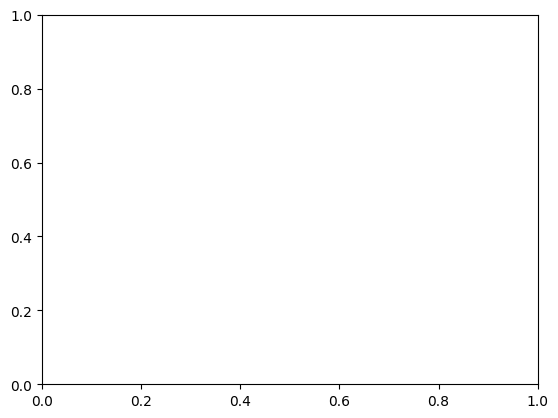

In [31]:
fig, ax = plt.subplots()
sns.lineplot(data=df_top_all_n[["plays5", "plays10", "plays20"]])

---
Graphing the five most played song with their respective **plays per month**.

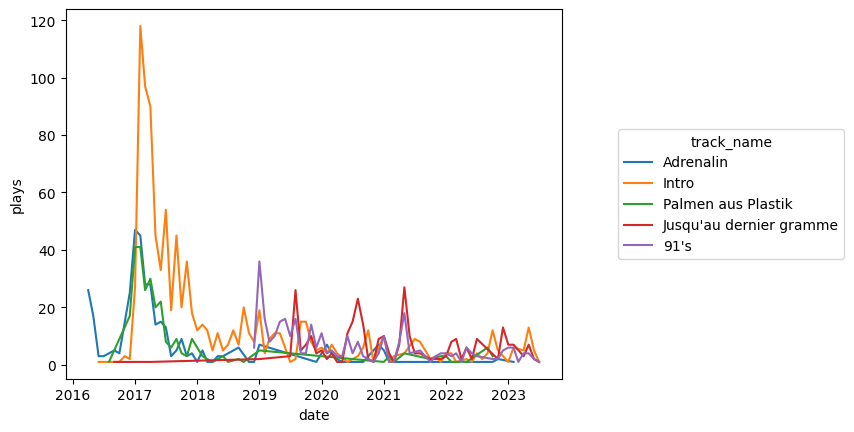

In [32]:
top10 = df["master_metadata_track_name"].value_counts().iloc[:5].index.values
data = df[df["master_metadata_track_name"].isin(top10)]
data = data.groupby([data["ts"].dt.year, data["ts"].dt.month], group_keys=False) \
    ["master_metadata_track_name"].value_counts().to_frame().rename_axis(["year", "month", "track_name"]).reset_index(2) \
    .rename({"count":"plays"}, axis=1).reset_index()
data["date"] = pd.to_datetime(data[["year", "month"]].assign(DAY=1))
data = data.drop(["year", "month"], axis=1)


ax = sns.lineplot(data=data, x="date", y="plays", hue="track_name")
sns.move_legend(ax, "center left", bbox_to_anchor=(1.1,0.5))

---
Hearing by Weekday.

<Axes: xlabel='weekday', ylabel='count'>

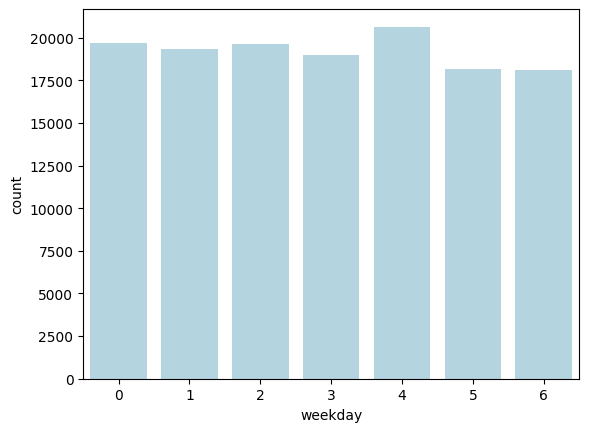

In [33]:
df_weekday_plays = df_orig.groupby(df_orig["ts"].dt.weekday)["ts"].count().to_frame()
df_weekday_plays.index.rename("weekday", inplace=True)
df_weekday_plays.reset_index(inplace=True)
df_weekday_plays.rename({"ts":"count"}, inplace=True, axis=1)

sns.barplot(data=df_weekday_plays, x="weekday", y="count", color="lightblue")

<Axes: xlabel='hour', ylabel='count'>

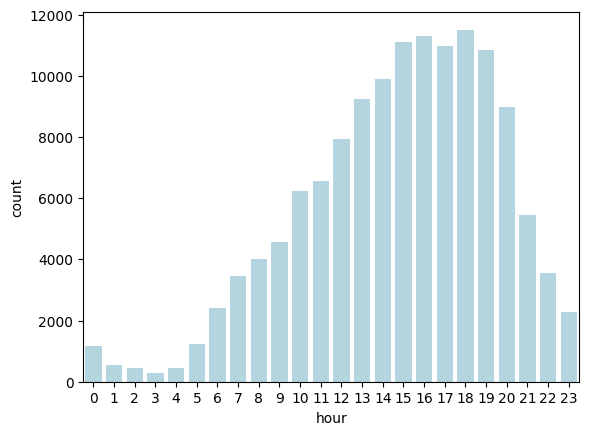

In [34]:
df_weekday_plays = df_orig.groupby(df_orig["ts"].dt.hour)["ts"].count().to_frame()
df_weekday_plays.index.rename("hour", inplace=True)
df_weekday_plays.reset_index(inplace=True)
df_weekday_plays.rename({"ts":"count"}, inplace=True, axis=1)

sns.barplot(data=df_weekday_plays, x="hour", y="count", color="lightblue")

/home/voss/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


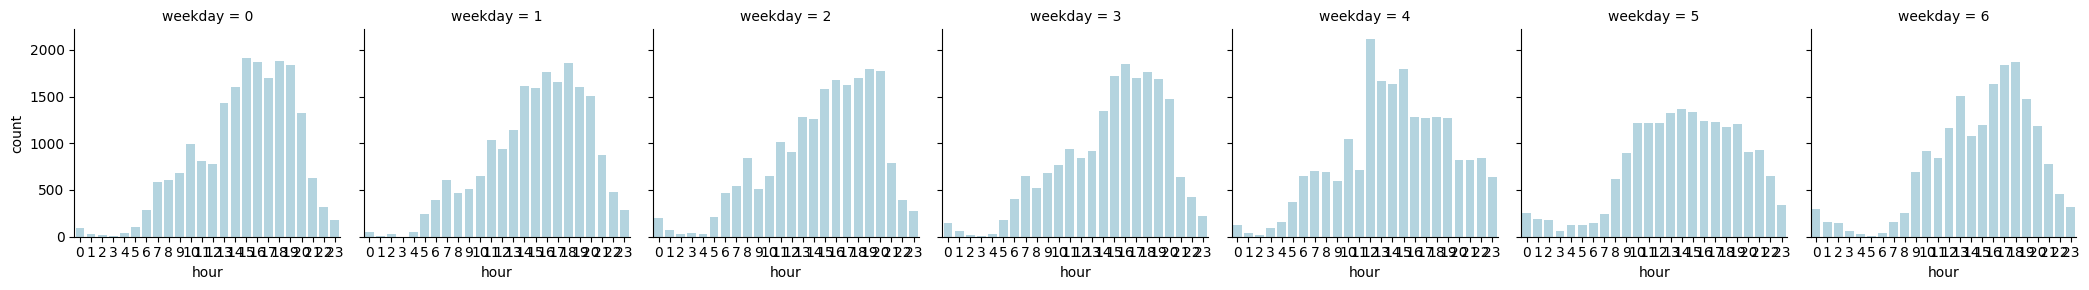

In [35]:
df_weekday_plays = df_orig.groupby([df_orig["ts"].dt.weekday, df_orig["ts"].dt.hour])["ts"].count().to_frame()
df_weekday_plays.columns = ["count"]
df_weekday_plays.index.rename(["weekday", "hour"], inplace=True)
df_weekday_plays = df_weekday_plays.reset_index()

sea = sns.FacetGrid(df_weekday_plays, col="weekday")
sea.map(sns.barplot, "hour", "count", color="lightblue")

---
# Interpretes

In [36]:
df_artist = df_orig[["ts", "master_metadata_track_name", "master_metadata_album_artist_name"]].rename(\
    columns={"master_metadata_track_name":"track_name","master_metadata_album_artist_name":"artist_name"})
df_artist.head()

,ts,track_name,artist_name
0,2023-05-29 18:08:46+00:00,I Just Can't Wait to Be King,JD McCrary
1,2023-05-29 18:08:59+00:00,You and Me (But Mostly Me),Josh Gad
2,2023-05-29 18:14:00+00:00,Bangkok / One Night In Bangkok,Murray Head
3,2023-05-29 18:17:00+00:00,The Way I Are,Timbaland
4,2023-05-29 18:17:18+00:00,Fahr mit mir (4x4) (feat. Tokio Hotel),Kraftklub


In [37]:
n = 10
top_n = df_artist.groupby(df_artist["ts"].dt.year)["artist_name"].value_counts().groupby(level=0, group_keys=False).head(n).to_frame().reset_index()
top_n["songs"] = np.zeros(len(top_n)).astype(int)
top_n["var"] = np.zeros(len(top_n))
top_n["std"] = np.zeros(len(top_n))
for i, row in top_n.iterrows():
    data = df_artist.loc[(df_artist["artist_name"] == row["artist_name"]) & (df_artist["ts"].dt.year == row["ts"])]
    individual_tracks = data["track_name"].value_counts()
    top_n.at[i, "songs"] = len(individual_tracks)
    top_n.at[i, "var"] = individual_tracks.var()
    top_n.at[i, "std"] = individual_tracks.std()
top_n = top_n.round(2)
top_n.head(3)

,ts,artist_name,count,songs,var,std
0,2014,Bastille,60,35,1.92,1.38
1,2014,Marteria,49,27,1.16,1.08
2,2014,Michael Jackson,26,19,0.58,0.76


In [45]:
top_n.sort_values("count", ascending=False)[:20]

,ts,artist_name,count,songs,var,std
30,2017,Kontra K,8875,158,3941.21,62.78
31,2017,Bonez MC,2748,85,2995.27,54.73
32,2017,Gzuz,2666,55,4648.96,68.18
80,2022,Depeche Mode,2517,245,54.02,7.35
50,2019,PNL,2268,41,1038.22,32.22
60,2020,PNL,2202,48,440.54,20.99
33,2017,AK AUSSERKONTROLLE,2143,62,1276.25,35.72
90,2023,Depeche Mode,2087,240,59.79,7.73
40,2018,RAF Camora,1899,79,288.27,16.98
41,2018,Joshi Mizu,1757,64,596.57,24.42


---
## Artist stats

In [40]:
### config ###
calculate = True
##############

if calculate:
    df_art = df_artist["artist_name"].value_counts().to_frame().reset_index().rename(columns={"count":"plays"})
    df_art["songs"] = np.zeros(len(df_art)).astype(int)
    df_art["var"] = np.zeros(len(df_art))
    df_art["std"] = np.zeros(len(df_art))
    for i, row in df_art.iterrows():
        data = df_artist.loc[df_artist["artist_name"] == row["artist_name"]]
        individual_tracks = data["track_name"].value_counts()
        df_art.at[i, "songs"] = len(individual_tracks)
        df_art.at[i, "var"] = individual_tracks.var()
        df_art.at[i, "std"] = individual_tracks.std()
    df_art.to_csv("df_art_niklas.csv")
else:
    df_art = pd.read_csv("df_art.csv")
df_art.head(3)

,artist_name,plays,songs,var,std
0,Kontra K,12009,202,5247.393059,72.438892
1,PNL,7777,54,7326.395877,85.594368
2,Depeche Mode,7150,306,402.285267,20.057050


---
# Listening time

In [41]:
df_ms = df_orig[["ts", "ms_played", "master_metadata_track_name", "master_metadata_album_artist_name"]]
df_ms = df_ms.rename(columns={"master_metadata_track_name":"track_name", "master_metadata_album_artist_name":"artist_name"})
df_ms.head()

,ts,ms_played,track_name,artist_name
0,2023-05-29 18:08:46+00:00,202986,I Just Can't Wait to Be King,JD McCrary
1,2023-05-29 18:08:59+00:00,11392,You and Me (But Mostly Me),Josh Gad
2,2023-05-29 18:14:00+00:00,302213,Bangkok / One Night In Bangkok,Murray Head
3,2023-05-29 18:17:00+00:00,179120,The Way I Are,Timbaland
4,2023-05-29 18:17:18+00:00,226,Fahr mit mir (4x4) (feat. Tokio Hotel),Kraftklub


### Basic stats

Time played: 6803.71 hours or 283.49 days 

 Per year: Axes(0.125,0.11;0.775x0.77)


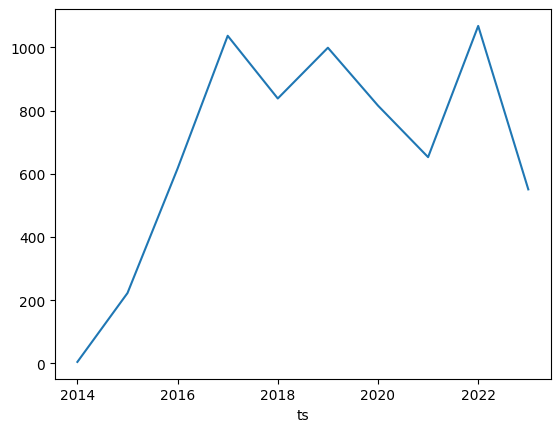

In [42]:
time_sum = df_ms["ms_played"].sum()
dates = df_ms["ts"].dt.strftime("%y - %m").drop_duplicates().tolist()
time_year = df_ms.groupby(df_ms["ts"].dt.year)["ms_played"].sum().apply(lambda x: x/1000/60/60).plot()
print(f"Time played: {np.round(time_sum/1000/60/60, 2)} hours or {np.round(time_sum/1000/60/60/24, 2)} days \n\n Per year: {time_year}")

<Axes: xlabel='ts,ts'>

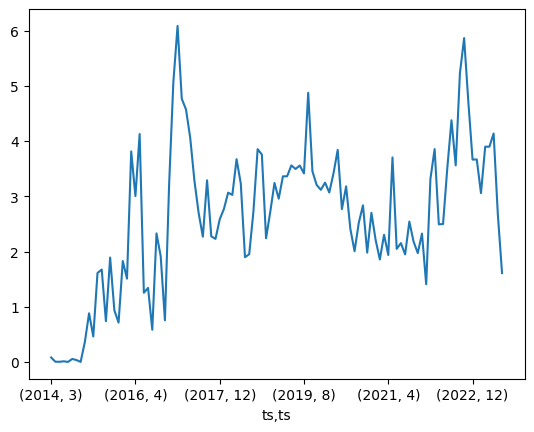

In [43]:
time_yearmonth = df_ms.groupby([df_ms["ts"].dt.year, df_ms["ts"].dt.month])["ms_played"].sum().apply(lambda x: x/1000/60/60/24)
time_yearmonth.plot()

---
## Playtime per song

In [44]:
song_playtime = df_ms.groupby("track_name")["ms_played"].mean()
song_playtime

track_name
"we circle through the night, consumed by fire" - Recorded at Spotify Studios NYC    594700.000000
# fuori c'è il sole                                                                    4993.000000
#DIY                                                                                 137759.954545
#HeyJu (feat. CrispyRob & Vincent Lee)                                                20559.000000
#WHERESTHELOVE - Charity Single                                                        2439.000000
                                                                                         ...      
不許你注定一人                                                                                8624.000000
原來她不夠愛我                                                                                8873.000000
念念不忘                                                                                  10818.000000
羅生門                                                                                   15413.000000

---
#Ideas
- 💡 for every year, number of songs played for that amount
- top song percentage
- genre breaks
- play peaks / lows
- top genres
- genre percentage
- interpret percentage
- popularity stats
- top interpretes
- mean playtime @(month/day/hour)
- skipped
    - time
    - percentage
    - heared again?
    - skipped early/late -> heared again?
    - main genre? -> skipped?
- session recognition?
- song cluster